In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1-Import Modules**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

# **2-Preparing the paths of input images and target segmentation masks**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Exploring and Visualizing the data
    </font>
</div>

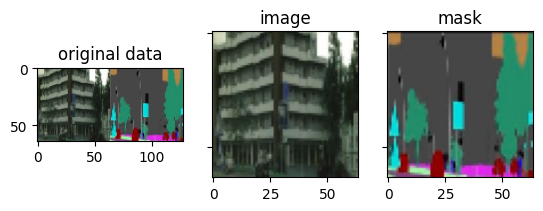

In [3]:
img_path = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.set_title('original data')
ax1.imshow(img);
ax2.set_title('image')
ax2.imshow(img[0:64, 0:64]);
ax3.set_title('mask')
ax3.imshow(img[0:64, 64:128]);

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Preprocesing Images
    </font>
</div>

In [4]:
def preprocess_images(path: str):
    X = []
    Y = []
    directory = path 
    for image in os.listdir(directory):
        img = cv2.imread(directory+image)
        img = cv2.resize(img, (128, 128))
        #Train
        cropped_image_train = img[0:64, 0:64]
        X.append(cropped_image_train)
        #Validation
        cropped_image_valid = img[0:64, 64:128]
        Y.append(cropped_image_valid)
    return X, Y

In [5]:
X_train, Y_train = preprocess_images("/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/")
X_valid, Y_valid = preprocess_images("/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/")

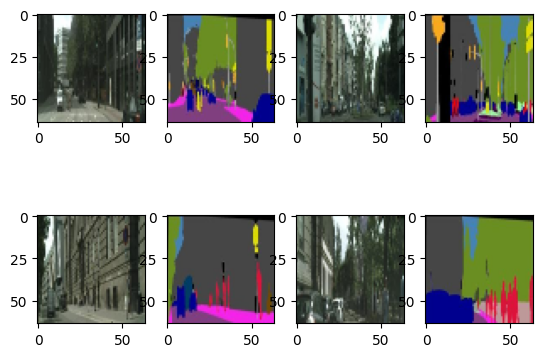

In [6]:
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(X_train[0], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 2)
plt.imshow(cv2.cvtColor(Y_train[0], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 3)
plt.imshow(cv2.cvtColor(X_train[1], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 4)
plt.imshow(cv2.cvtColor(Y_train[1], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 5)
plt.imshow(cv2.cvtColor(X_train[2], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 6)
plt.imshow(cv2.cvtColor(Y_train[2], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 7)
plt.imshow(cv2.cvtColor(X_train[3], cv2.COLOR_BGR2RGB));
plt.subplot(2, 4, 8)
plt.imshow(cv2.cvtColor(Y_train[3], cv2.COLOR_BGR2RGB));

In [7]:
X_train = np.array(X_train, dtype='float32')/255.0
Y_train = np.array(Y_train, dtype='float32')/255.0
X_valid = np.array(X_valid, dtype='float32')/255.0
Y_valid = np.array(Y_valid, dtype='float32')/255.0

# **3-Creating the U-Net architecture**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Building the convolutional block
    </font>
</div>

In [8]:
def ConvBlock(x, n_filters):
    # Taking first input and implementing the first conv block
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    return x

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Building the encoder
    </font>
</div>

In [9]:
def downsample_block(x, n_filters):
    f = ConvBlock(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Building the decoder
    </font>
</div>

In [10]:
def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = ConvBlock(x, n_filters)
    return x

In [11]:
X_train[0].shape

(64, 64, 3)

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Building & Compile UNet model
    </font>
</div>

In [12]:
def build_unet_model(output_channels):
    # input layer
    inputs = layers.Input(shape=(64, 64, 3))

    # encoder - downsample
    f1, p1 = downsample_block(inputs, 32)
    f2, p2 = downsample_block(p1, 64)
    f3, p3 = downsample_block(p2, 128)
    f4, p4 = downsample_block(p3, 256)

    # intermediate block
    intermediate_block = ConvBlock(p4, 512)

    # decoder - upsample
    u6 = upsample_block(intermediate_block, f4, 256)
    u7 = upsample_block(u6, f3, 128)
    u8 = upsample_block(u7, f2, 64)
    u9 = upsample_block(u8, f1, 32)

    # output layer
    outputs = layers.Conv2D(output_channels, 1, padding='same', activation='sigmoid')(u9)

    # unet model
    unet_model = tf.keras.Model(inputs, outputs, name='U-Net')

    return unet_model

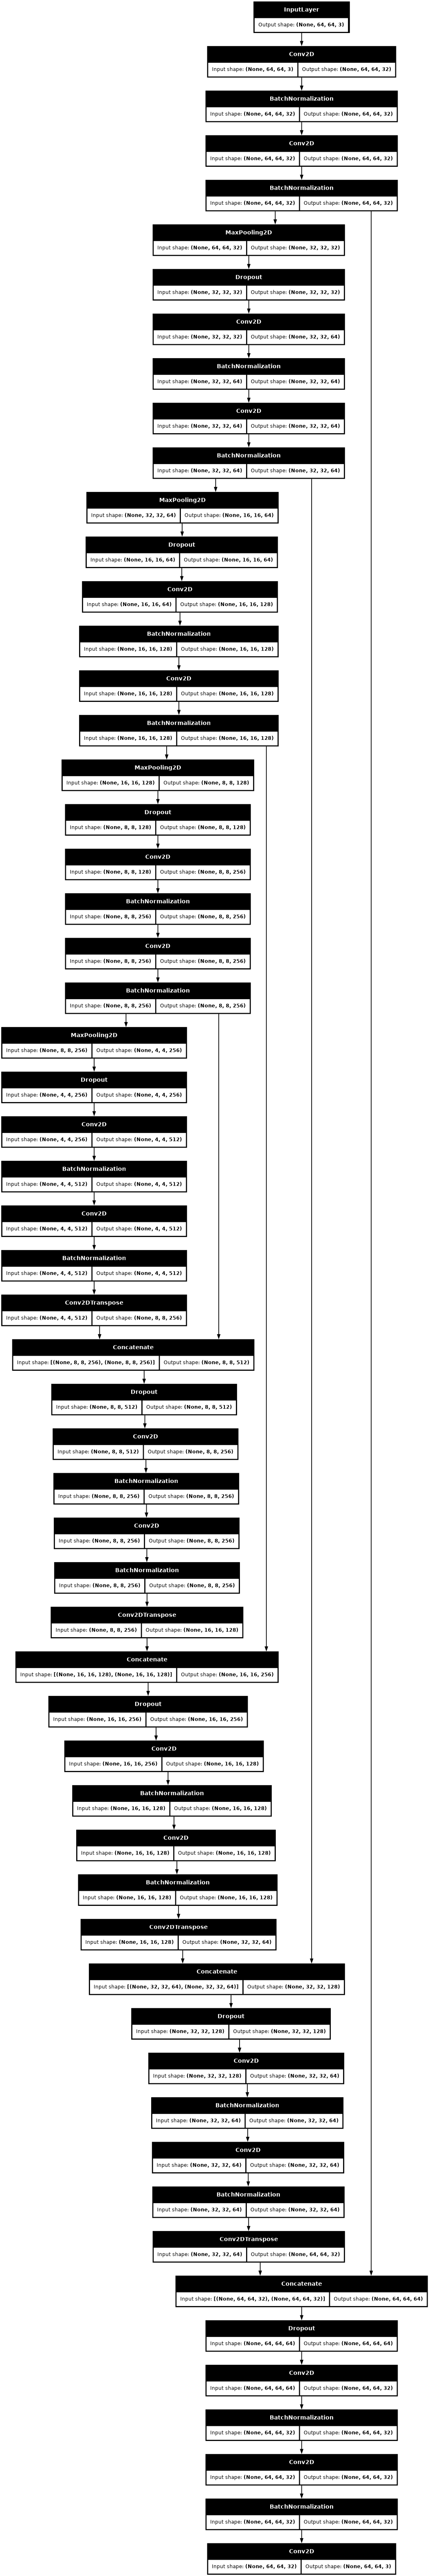

In [13]:
output_channels = 3
model = build_unet_model(output_channels)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=False, dpi=64)

In [14]:
history = model.fit(X_train, Y_train, epochs= 60, verbose=0, validation_data=(X_valid, Y_valid))

I0000 00:00:1732095078.338244      70 service.cc:145] XLA service 0x7a1670002e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732095078.338304      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732095078.338308      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732095101.795297      70 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_5', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732095101.827582      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
I0000 00:00:1732095128.047033      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_5', 8 bytes spill stores, 8 bytes spill loads



<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
plot results
    </font>
</div>

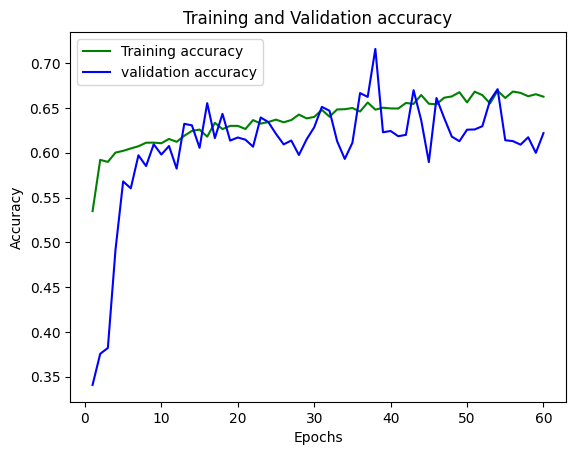

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1,history.epoch[-1]+2)
plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

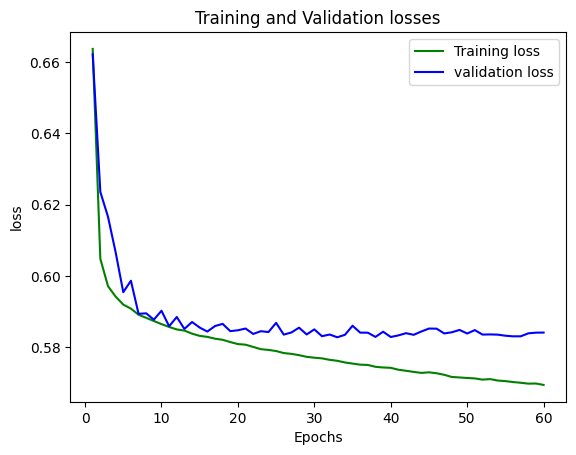

In [16]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# **4-Viewing the prediction of the constructed U-Net model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


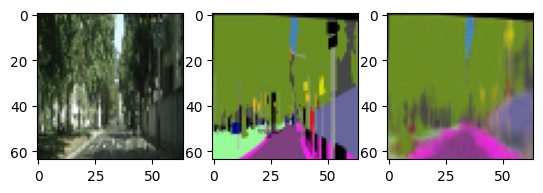

In [17]:
image_id_test = 32
X_tmp = X_valid[image_id_test]
X_tmp = np.expand_dims(X_tmp, axis=0)

y_tmp = model.predict(X_tmp)

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(X_valid[image_id_test], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(Y_valid[image_id_test], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(y_tmp[0], cv2.COLOR_BGR2RGB))